In [10]:
import scanpy as sc
from tidyverse.dummy import *

from sctools.scplotting import recolor
import gc
import pertpy as pt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
from sctools.composition import compositional_pca, plot_pca_loadings
plt.rcParams["figure.figsize"] = (4,3)

from prop_utils import annotate_qval_to_scCODA_result, renamer

import sys
sys.path.append('..')
from util import load_celltype
from colormaps import color_dict_diagnosis, cmap_subtypes
from matplotlib.colors import ListedColormap


/tmp/ipykernel_148548/1623901182.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


make the matplotlib plots as svgs for easy export.
**Note**: some umaps with MANY cells will get HUGE

In [2]:
mkdir /tmp/proportions

mkdir: cannot create directory ‘/tmp/proportions’: File exists


In [3]:
plotfolder = '/tmp/proportions/Fibroblast_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# SCCODA

In [4]:
A = load_celltype('Fibroblasts')

In [5]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

In [6]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    A,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

In [7]:
cluster_order = ['3','2','4','8','0']
cluster_order = cluster_order + [i for i in data_scanpy_1.var.index if i not in cluster_order]

changin the colormap to reflect the different fibroblast subpopulations

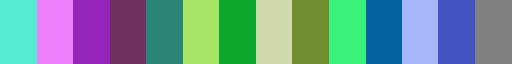

In [11]:
#move some colors around, so that the NS sepcific Fibs get the same hue
#  NE spec        # NS            # Pan            # rest
cm_colors = cmap_subtypes.colors
cmap_subtypes = ListedColormap(cm_colors[0:1] + cm_colors[10:13] + cm_colors[1:2] + cm_colors[2:7] + cm_colors[7:10] +cm_colors[13:])
cmap_subtypes

In [12]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

/tmp/ipykernel_148548/1851171365.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_148548/1851171365.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


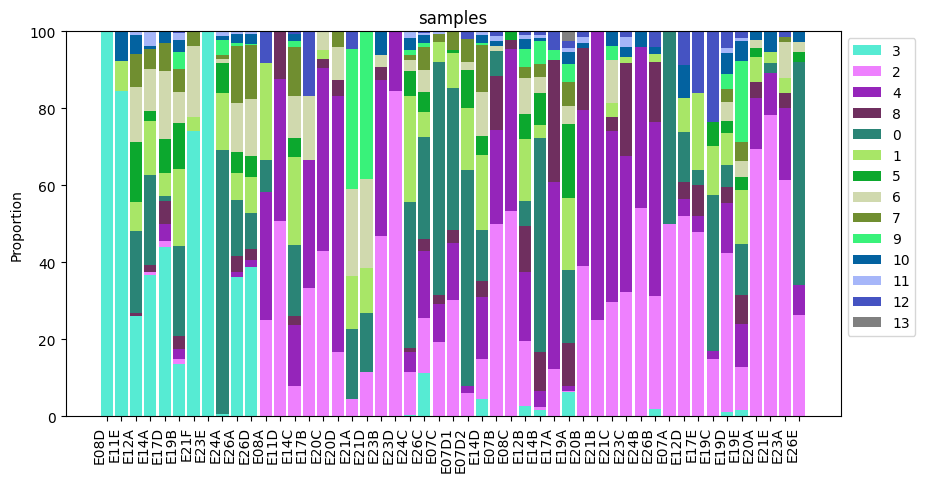

In [13]:
order = []
_s = data_scanpy_1.obs.index
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.query('diagnosis==@d and samplename in @_s').index))

set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(10,5), show=False, palette=cmap_subtypes,
    level_order=order
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Fibroblast_proportions_per_sample.svg')
set_matplotlib_formats('png')

In [14]:
# clustered_heatmap_from_sccoda_CLR(data_scanpy_1, barcolormap=cmap_subtypes);

## CODA-PCA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1010.70it/s]


<Axes: xlabel='leiden'>

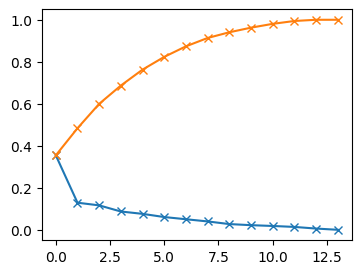

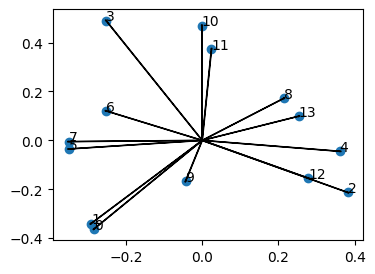

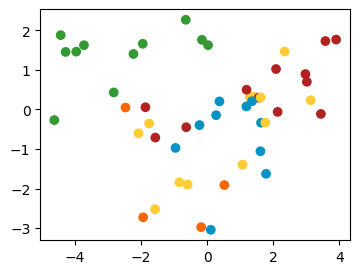

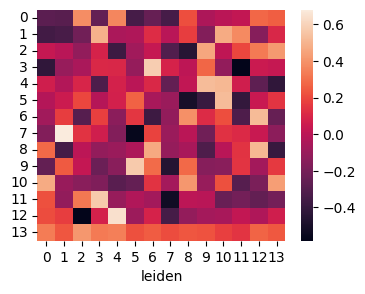

In [15]:
pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(data_scanpy_1)
plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

# plot_pca_with_uncertainty()
plt.figure()
plot_pca_loadings(principal_components_df)

plt.figure()
plt.scatter(x_pca_posterior[:,0], x_pca_posterior[:,1], c=[color_dict_diagnosis[_] for _ in data_scanpy_1.obs.diagnosis])

plt.figure()
sns.heatmap(principal_components_df)

## Barplots

/tmp/ipykernel_148548/3420428502.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_148548/3420428502.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


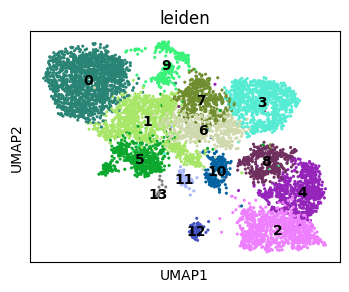

In [16]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Fibroblast_umap.svg')
plt.savefig(f'{plotfolder}/Fibroblast_umap.png')
set_matplotlib_formats('png')

/tmp/ipykernel_148548/676935331.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_148548/676935331.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


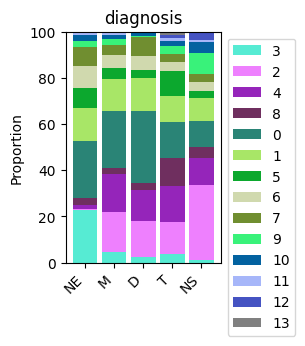

In [17]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_subtypes
)
fig.figure.savefig(f'{plotfolder}/Fibroblast_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Fibroblast_proportions//proportions_per_diagnosis_ncells.svg


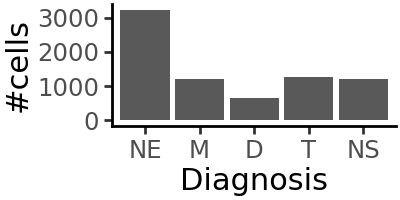

In [18]:
p = pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index(), pn.aes(x='diagnosis', y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic() + pn.theme(figure_size=(2,1)) + pn.labs(x='Diagnosis', y='#cells')
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

In [22]:
# how many purple cells in mNE

In [23]:
(data_scanpy_1[data_scanpy_1.obs.diagnosis=="NE"].X.sum(0) / 3237)[[2,4,8]].sum()

0.05282669138090825

In [24]:
set_matplotlib_formats('png')

/tmp/ipykernel_3934950/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [25]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)

In [26]:
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_3934950/93466688.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Fibroblast_proportions//Fibroblast_proportions_per_cluster.svg
/tmp/ipykernel_3934950/93466688.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


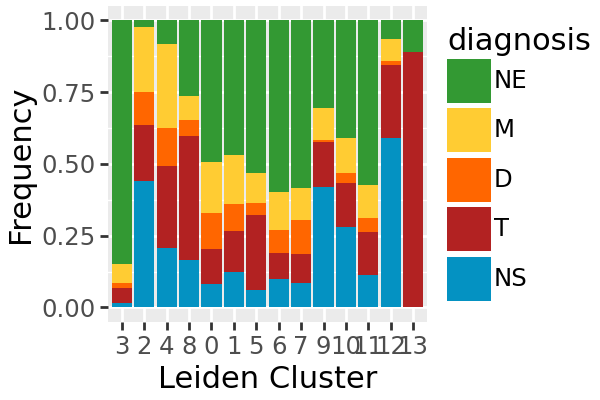

In [27]:
set_matplotlib_formats('svg')
p = pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')
p.save(f'{plotfolder}/Fibroblast_proportions_per_cluster.svg')
set_matplotlib_formats('png')
p


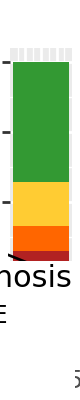

In [28]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'count': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Fibroblast_proportions//proportions_per_cluster_ncells.svg


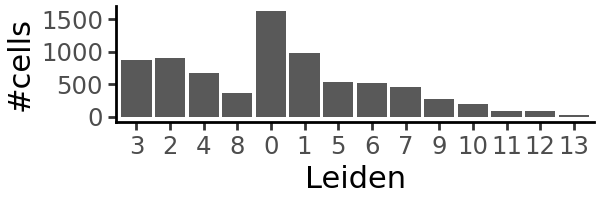

In [29]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=['leiden']).groupby('leiden').value.sum()}).reset_index(), pn.aes(x='leiden', y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic()  + pn.theme(figure_size=(3,1)) + pn.labs(x='Leiden', y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

## MCMC

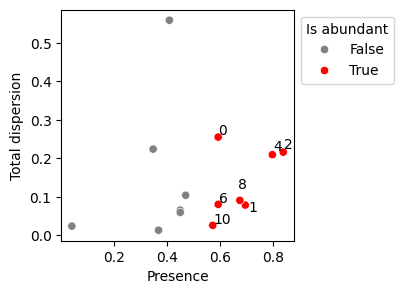

In [31]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3), abundant_threshold=0.5); plt.show()

In [32]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + patient + procedure",
    reference_cell_type="1",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|███████████| 11000/11000 [19:10<00:00,  9.56it/s, 511 steps of size 9.38e-03. acc. prob=0.79]


AnnData object with n_obs × n_vars = 49 × 14
    obs: 'procedure', 'diagnosis', 'patient', 'samplename', 'n_cells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', 'effect_df_procedure[T.resection]'

In [33]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])

scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  HDI 3%  HDI 97%  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NE'))T.M  2                 2.046681   1.341    2.678   
                                  3                -2.187941  -2.880   -1.406   
                                  4                 1.746500   1.101    2.427   
C(diagnosis, Treatment('NE'))T.D  2                 2.235143   1.269    3.083   
                                  3                -2.682356  -3.765   -1.597   
                                  4                 1.650019   0.647    2.636   
                                  6                -1.348485  -2.527   -0.258   
C(diagnosis, Treatment('NE'))T.T  0                -0.706677  -1.250    0.009   
                                  2                 2.614880   1.894    3.306   
                                  3                -2.201464  -2.924   -1.495   
                                  4                 2.460280   1.736    3.105   
                                  6                -0.768180  -1.375    0.005   
                                  8                 1.479845   0.880    2.024   
C(diagnosis, Treatment('NE'))T.NS 2                 3.271207   2.578    3.959   
                                  3                -2.305845  -3.093   -1.557   
                                  4                 1.479517   0.710    2.216   
                                  12                1.036683  -0.003    1.672   
patientT.E14                      2                -1.006625  -1.856   -0.116   
patientT.E17                      2                -1.067890  -1.789   -0.366   
patientT.E19                      2                -1.437402  -2.099   -0.698   
                                  3                -0.769949  -1.464    0.011   
                                  4                -1.078347  -1.882   -0.261   
patientT.E21                      0                -0.835960  -1.551    0.003   
                                  9                 1.036731  -0.007    1.894   
patientT.E24                      3                -2.135889  -3.245   -1.066   
                                  6                -1.192851  -2.249   -0.166   
procedureT.resection              0                 1.338253   0.590    2.051   
                                  2                -1.715891  -2.302   -1.159   
                                  4                -1.887546  -2.519   -1.264   
                                  8                -1.447703  -2.081   -0.829   
                                  11               -0.825835  -1.477    0.007   
                                  12               -1.062633  -1.830   -0.310   
                                  13               -1.099527  -1.923   -0.241   

                                                SD  Inclusion probability  \
Covariate                         Cell Type                                 
C(diagnosis, Treatment('NE'))T.M  2          0.344                 1.0000   
                                  3          0.381                 1.0000   
                                  4          0.335                 1.0000   
C(diagnosis, Treatment('NE'))T.D  2          0.469                 1.0000   
                                  3          0.576                 1.0000   
                                  4          0.571                 0.9780   
                                  6          0.659                 0.9238   
C(diagnosis, Treatment('NE'))T.T  0          0.420                 0.7822   
                                  2          0.366                 1.0000   
                                  3          0.367                 1.0000   
                                  4          0.366                 1.0000   
                                  6          0.462                 0.7677   
                                  8          0.287                 1.0000   
C(diagnosis, Treatment('NE'))T.NS 2          0.363    

In [38]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_3934950/1088038068.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


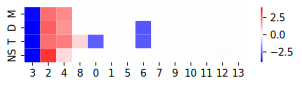

In [39]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(5, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_scCODA.svg')

In [40]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type                    0         1        10        11        12  \
Covariate                                                                
D                    -0.700030 -0.700030 -0.700030 -0.700030 -0.700030   
M                    -0.700180 -0.700180 -0.700180 -0.700180 -0.700180   
NS                   -1.543175 -1.543175 -1.543175 -1.543175 -0.047557   
T                    -2.527769 -1.508249 -1.508249 -1.508249 -1.508249   
patientT.E08          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E11          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E12          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E14          0.068617  0.068617  0.068617  0.068617  0.068617   
patientT.E17          0.071024  0.071024  0.071024  0.071024  0.071024   
patientT.E19          0.501601  0.501601  0.501601  0.501601  0.501601   
patientT.E20          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E21         -1.229460 -0.023425 -0.023425 -0.023425 -0.023425   
patientT.E23          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E24          0.611477  0.611477  0.611477  0.611477  0.611477   
patientT.E26          0.000000  0.000000  0.000000  0.000000  0.000000   
procedureT.resection  2.153089  0.222398  0.222398 -0.969030 -1.310657   

Cell Type                   13         2         3         4         5  \
Covariate                                                                
D                    -0.700030  2.524599 -4.569851  1.680445 -0.700030   
M                    -0.700180  2.252557 -3.856712  1.819487 -0.700180   
NS                   -1.543175  3.176179 -4.869807  0.591317 -1.543175   
T                    -1.508249  2.264226 -4.684290  2.041185 -1.508249   
patientT.E08          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E11          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E12          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E14          0.068617 -1.383635  0.068617  0.068617  0.068617   
patientT.E17          0.071024 -1.469615  0.071024  0.071024  0.071024   
patientT.E19          0.501601 -1.572131 -0.609201 -1.054124  0.501601   
patientT.E20          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E21         -0.023425 -0.023425 -0.023425 -0.023425 -0.023425   
patientT.E23          0.000000  0.000000  0.000000  0.000000  0.000000   
patientT.E24          0.611477  0.611477 -2.469959  0.611477  0.611477   
patientT.E26          0.000000  0.000000  0.000000  0.000000  0.000000   
procedureT.resection -1.363884 -2.253109  0.222398 -2.500755  0.222398   

Cell Type                    6         7         8         9  
Covariate                                                     
D                    -2.645482 -0.700030 -0.700030 -0.700030  
M                    -0.700180 -0.700180 -0.700180 -0.700180  
NS                   -1.543175 -1.543175 -1.543175 -1.543175  
T                    -2.616498 -1.508249  0.626716 -1.508249  
patientT.E08          0.000000  0.000000  0.000000  0.000000  
patientT.E11          0.000000  0.000000  0.000000  0.000000  
patientT.E12          0.000000  0.000000  0.000000  0.000000  
patientT.E14          0.068617  0.068617  0.068617  0.068617  
patientT.E17          0.071024  0.071024  0.071024  0.071024  
patientT.E19          0.501601  0.501601  0.501601  0.501601  
patientT.E20          0.000000  0.000000  0.000000  0.000000  
patientT.E21         -0.023425 -0.023425 -0.023425  1.472261  
patientT.E23          0.000000  0.000000  0.000000  0.000000  
patientT.E24         -1.109443  0.611477  0.611477  0.611477  
patientT.E26          0.000000  0.000000  0.000000  0.000000  
procedureT.resection  0.222398  0.222398 -1.866195  0.222398

# Markers for paper

In [41]:
sc.pl.umap(A, color=['leiden', 'n_genes','n_molecules', 'percent_mito'], legend_loc='on data', size=20)

/tmp/ipykernel_148548/2281238948.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


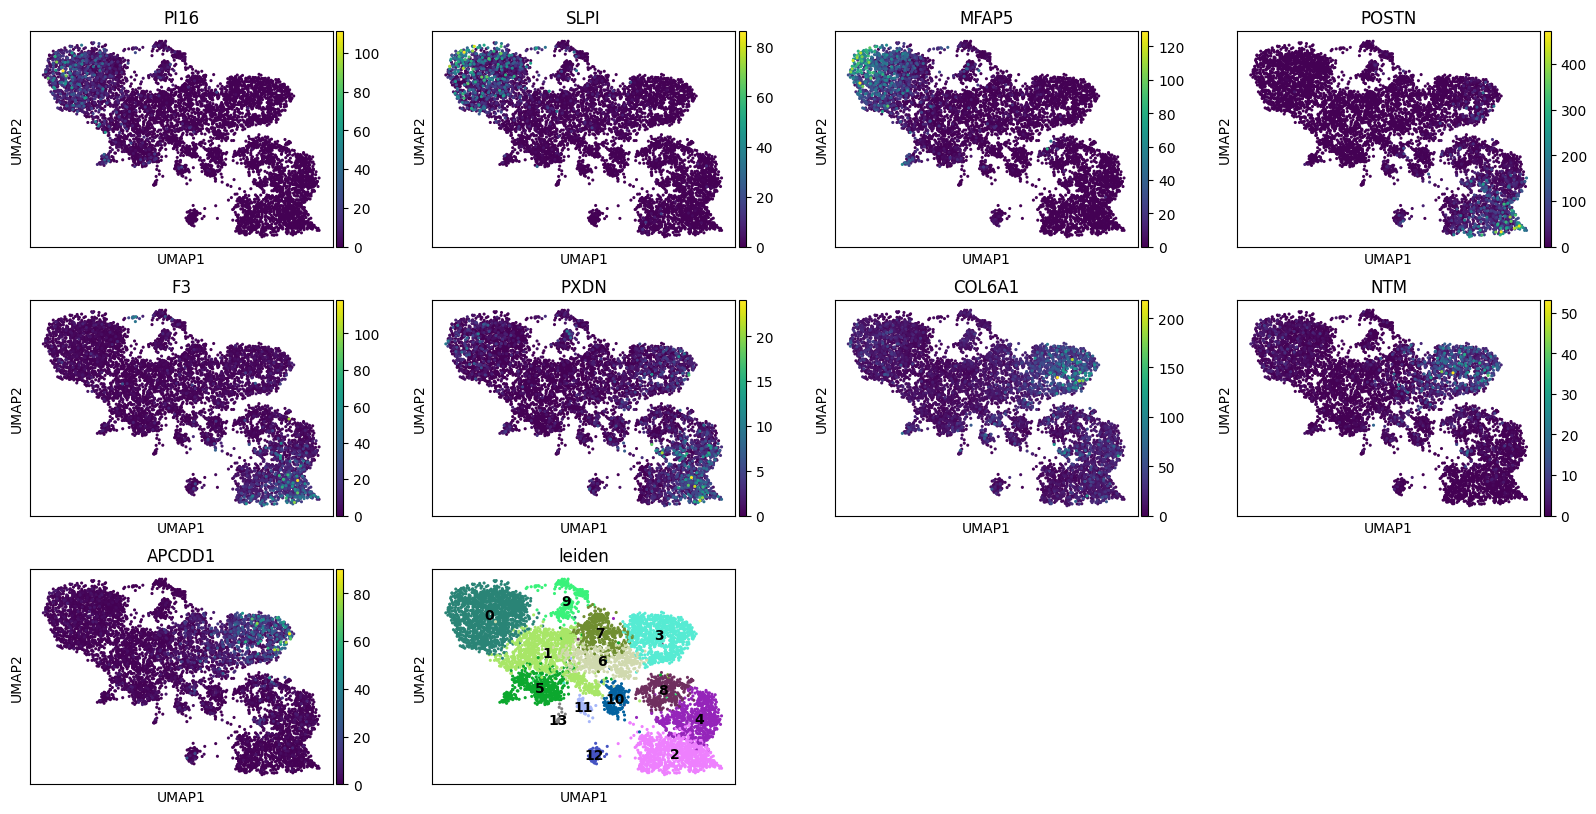

/tmp/ipykernel_148548/2281238948.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


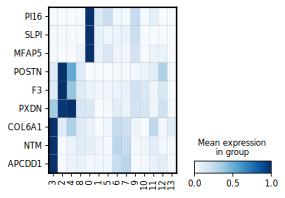

In [20]:
genes =['PI16','SLPI','MFAP5',
        'POSTN', 'F3','PXDN',
        'COL6A1','NTM', 'APCDD1']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.raw = B
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, use_raw=True, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Fibroblast_markers_matrix.svg')